In [22]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!pip install geocoder
import geocoder # to get coordinates
!pip install requests 
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
!pip install folium
import folium # map rendering library

print("Libraries imported.")

Libraries imported.


In [23]:
data = requests.get("https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Pune").text
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')
# create a list to store neighborhood data
neighborhood_List = []
# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhood_List.append(row.text)

# create a new DataFrame from the list
Pune_df = pd.DataFrame({"Neighborhood": neighborhood_List})

Pune_df.tail()

,Neighborhood
53,Vishrantwadi
54,Wakad
55,Wanwadi
56,Warje
57,Yerawada


In [0]:
Pune_df.drop( Pune_df.index[55],   inplace = True)
Pune_df.drop( Pune_df.index[9],   inplace = True)
Pune_df.reset_index(drop=True ,  inplace=True)

In [0]:

# define a function to get coordinates
def get_cord(neighborhood):
 
    coords = None
    # loop until you get the coordinates
    while(coords is None):
        g = geocoder.arcgis('{}, Pune, Maharashtra'.format(neighborhood))
        coords = g.latlng
    return coords

In [0]:

# create a  list and store the coordinates 
coords = [ get_cord(neighborhood) for neighborhood in Pune_df["Neighborhood"].tolist() ]

In [27]:

coords[:10]

[[18.516478861794244, 73.85386842926913],
 [18.563450000000046, 73.81227000000007],
 [18.576020000000028, 73.77983000000006],
 [18.548200000000065, 73.77316000000008],
 [18.517541553892233, 73.77852901740273],
 [18.512975860118864, 73.86528927407815],
 [18.581196108649767, 73.98546048802743],
 [18.516890000000046, 73.85617000000008],
 [18.512447939109023, 73.85657369435856],
 [18.515850000000057, 73.84061000000008]]

In [0]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [29]:
# merge the coordinates into the original dataframe
Pune_df['Latitude'] = df_coords['Latitude']
Pune_df['Longitude'] = df_coords['Longitude']

# check the neighborhoods and the coordinates
print(Pune_df.shape)
Pune_df.head(10)

(56, 3)


,Neighborhood,Latitude,Longitude
0,Appa Balwant Chowk,18.516479,73.853868
1,"Aundh, Pune",18.563450,73.812270
2,Balewadi,18.576020,73.779830
3,Baner,18.548200,73.773160
4,Bavdhan,18.517542,73.778529
5,"Bhavani Peth, Pune",18.512976,73.865289
6,Blue Ridge Town Pune,18.581196,73.985460
7,"Budhwar Peth, Pune",18.516890,73.856170
8,"Chakan, Pune",18.512448,73.856574
9,Deccan Gymkhana,18.515850,73.840610


In [0]:
# save the DataFrame as CSV file
Pune_df.to_csv("Pune_df.csv", index=False)

In [31]:

address = 'Pune, Maharashtra'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Pune, Maharashtra are  {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Pune, Maharashtra are  18.521428, 73.8544541.


In [32]:

# create map of Pune using latitude and longitude values
map_Pune = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(Pune_df['Latitude'], Pune_df['Longitude'], Pune_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_Pune)  
    
map_Pune

In [0]:
# save the map as HTML file
map_Pune.save('map_Pune.html')

In [1]:

# define Foursquare Credentials and Version
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
CLIENT_SECRET:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [0]:
radius = 3000
LIMIT = 150

venues = []

for lat, long, neighborhood in zip(Pune_df['Latitude'], Pune_df['Longitude'], Pune_df['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [36]:

# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df

(4464, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Appa Balwant Chowk,18.516479,73.853868,Sujata Mastani,18.511793,73.852145,Ice Cream Shop
1,Appa Balwant Chowk,18.516479,73.853868,Bhagat Tarachand,18.514332,73.851317,Indian Restaurant
2,Appa Balwant Chowk,18.516479,73.853868,Raja Dinkar Kelkar museum,18.510744,73.854389,History Museum
3,Appa Balwant Chowk,18.516479,73.853868,Hotel Madhuban,18.519248,73.848688,Tea Room
4,Appa Balwant Chowk,18.516479,73.853868,Mad Over Donuts,18.519335,73.845320,Donut Shop
5,Appa Balwant Chowk,18.516479,73.853868,Lal Mahal,18.518720,73.856556,Historic Site
6,Appa Balwant Chowk,18.516479,73.853868,Tilak Hotel,18.509603,73.846883,Snack Place
7,Appa Balwant Chowk,18.516479,73.853868,Krishna Juice Bar,18.523553,73.847651,Juice Bar
8,Appa Balwant Chowk,18.516479,73.853868,Shree Wadeshwar Bhuvan,18.510753,73.853748,Vegetarian / Vegan Restaurant
9,Appa Balwant Chowk,18.516479,73.853868,Café GoodLuck,18.517388,73.841485,Café


In [37]:

print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 146 uniques categories.


In [42]:

# print out the list of categories
venues_df['VenueCategory'].unique()

array(['Ice Cream Shop', 'Indian Restaurant', 'History Museum',
       'Tea Room', 'Donut Shop', 'Historic Site', 'Snack Place',
       'Juice Bar', 'Vegetarian / Vegan Restaurant', 'Café', 'BBQ Joint',
       'Bistro', 'Coffee Shop', 'Fast Food Restaurant',
       'South Indian Restaurant', 'Sandwich Place',
       'Maharashtrian Restaurant', 'Stadium', 'Trail',
       'Italian Restaurant', 'Seafood Restaurant', 'Frozen Yogurt Shop',
       'Gym', 'Bakery', 'Supermarket', 'Hotel', 'Food Truck', 'Bar',
       'Burger Joint', 'Steakhouse', 'Plaza', 'Dessert Shop',
       'Restaurant', 'Deli / Bodega', 'Sports Bar', 'Lounge',
       'Theme Park', 'Hotel Bar', 'Chinese Restaurant',
       'General Entertainment', 'Hookah Bar', 'Gastropub',
       'Sporting Goods Shop', 'Smoke Shop', 'Gym / Fitness Center',
       'Pizza Place', 'Shopping Mall', 'Breakfast Spot', 'Bookstore',
       'English Restaurant', 'Jewelry Store', 'Chocolate Shop',
       'Mexican Restaurant', 'Multiplex', 'Grocery 

In [43]:

# one hot encoding
Pune_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Pune_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Pune_onehot.columns[-1]] + list(Pune_onehot.columns[:-1])
Pune_onehot = Pune_onehot[fixed_columns]

print(Pune_onehot.shape)
Pune_onehot.head()

(4464, 147)


,Neighborhoods,Accessories Store,Airport,Airport Service,American Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach Bar,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Casino,Chaat Place,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lounge,Maharashtrian Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,New American Restaurant,Nightclub,North Indian Restaurant,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Parsi Restaurant,Pizza Place,Plaza,Pub,Punjabi Restaurant,Racetrack,Restaurant,River,Road,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Track Stadium,Trail,Train Station,Vegetarian / Vegan Restaurant,Watch Shop,Yoga Studio,Zoo
0,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
Pune_grouped = Pune_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(Pune_grouped.shape)
Pune_grouped['Total'] = Pune_grouped.sum(axis=1)
Pune_grouped

(56, 147)


,Neighborhoods,Accessories Store,Airport,Airport Service,American Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach Bar,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Casino,Chaat Place,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lounge,Maharashtrian Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,New American Restaurant,Nightclub,North Indian Restaurant,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Parsi Restaurant,Pizza Place,Plaza,Pub,Punjabi Restaurant,Racetrack,Restaurant,River,Road,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Track Stadium,Trail,Train Station,Vegetarian / Vegan Restaurant,Watch Shop,Yoga Studio,Zoo,Total
0,Appa Balwant Chowk,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.010000,0.020000,0.00,0.020000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.00,0.010000,0.000000,0.010000,0.000000,0.000000,0.050000,0.000000,0.00,0.000000,0.020000,0.00,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.000000,0.030000,0.00,0.000000,0.020000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.060000,0.000000,0.000000,0.010000,0.000000,0.000000,0.01,0.000000,0.000000,0.0,0.010000,0.01,0.000000,0.000000,0.00,0.020000,0.010000,0.010000,0.010000,0.010000,0.00,0.010000,0.010000,0.000000,0.020000,0.00000,0.130000,0.00,0.020000,0.00,0.00,0.000000,0.020000,0.000000,0.00,0.000000,0.010000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.020000,0.010000,0.000000,0.000000,0.000000,0.020000,0.000000,0.00,0.000000,0.00,0.020000,0.060000,0.00,0.010000,0.010000,0.050000,0.000000,0.020000,0.000000,0.010000,0.010000,0.010000,0.00,0.010000,0.010000,0.010000,0.00,0.000000,0.00,0.010000,0.000000,0.010000,0.00,0.050000,0.00,0.000000,0.000000,1.0
1,"Aundh, Pune",0.010000,0.000000,0.00000,0.000000,0.000000,0.010000,0.010000,0.040000,0.01,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.00,0.010000,0.010000,0.000000,0.010000,0.000000,0.050000,0.000000,0.00,0.000000,0.030000,0.01,0.010000,0.010000,0.020000,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.000000,0.030000,0.00,0.000000,0.010000,0.00000,0.000000,0.010000,0.010000,0.000000,0.00000,0.040000,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.01,0.020000,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.010000,0.000000,0.060000,0.00000,0.170000,0.00,0.010000,0.00,0.00,0.010000,0.020000,0.000000,0.01,0.000000,0

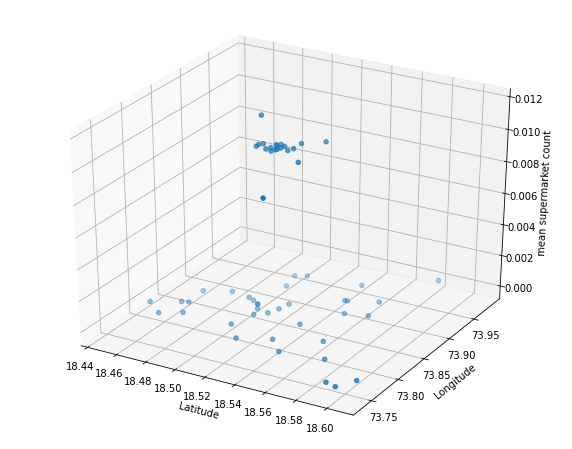

In [98]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

 
ax.scatter( Pune_df['Latitude'],Pune_df['Longitude'],Pune_grouped['Supermarket'] )

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('mean supermarket count')


plt.show()



In [88]:
Pune_Supermarket = Pune_grouped[["Neighborhoods","Supermarket"]]   
Pune_Supermarket.tail(10)

,Neighborhoods,Supermarket
46,Sopan Baug,0.00
47,"Sus, Pune",0.00
48,Swargate,0.01
49,Template:Neighbourhoods of Pune,0.00
50,Vadgaon Budruk,0.00
51,Vimannagar,0.00
52,Vishrantwadi,0.00
53,Wakad,0.00
54,Warje,0.00
55,Yerawada,0.00


In [109]:
# As we know K-means algorithm is sensetive to value of k  
# Instead of using a fixed value of k lets decide an optimum value of K using Elbow Method 
clustering = Pune_Supermarket.drop(["Neighborhoods"], 1)
from scipy.spatial.distance import cdist 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,5) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(clustering) 
    kmeanModel.fit(clustering)     
      
    distortions.append(sum(np.min(cdist(clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  del sys.path[0]


1 : 0.004629212149976271
2 : 5.523255813953724e-05
3 : 2.540130804108896e-18
4 : 5.8856689363498815e-19


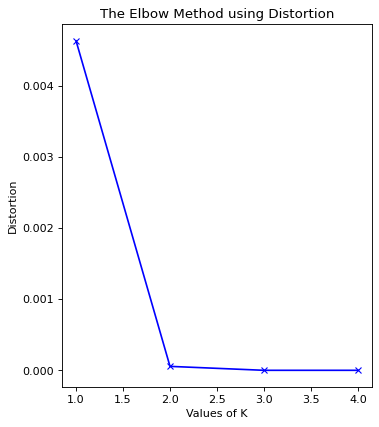

In [113]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure 
figure(num=None, figsize=(5, 6), dpi=80, facecolor='w', edgecolor='k')
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [107]:
numberofclusters  = 2


# run k-means clustering
kmeans = KMeans(n_clusters=numberofclusters , random_state=2).fit(clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0], dtype=int32)

In [92]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
merged = Pune_Supermarket.copy()

# add clustering labels
merged["Cluster Labels"] = kmeans.labels_

merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
merged.head()


,Neighborhood,Supermarket,Cluster Labels
0,Appa Balwant Chowk,0.01,1
1,"Aundh, Pune",0.00,0
2,Balewadi,0.00,0
3,Baner,0.00,0
4,Bavdhan,0.00,0


In [93]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(Pune_df.set_index("Neighborhood"), on="Neighborhood")

print(merged.shape)
merged.head() # check the last columns!

(56, 5)


,Neighborhood,Supermarket,Cluster Labels,Latitude,Longitude
0,Appa Balwant Chowk,0.01,1,18.516479,73.853868
1,"Aundh, Pune",0.00,0,18.563450,73.812270
2,Balewadi,0.00,0,18.576020,73.779830
3,Baner,0.00,0,18.548200,73.773160
4,Bavdhan,0.00,0,18.517542,73.778529


In [94]:

# sort the results by Cluster Labels
print(merged.shape)
merged.sort_values(["Cluster Labels"], inplace=True)
merged

(56, 5)


,Neighborhood,Supermarket,Cluster Labels,Latitude,Longitude
55,Yerawada,0.000000,0,18.569060,73.881590
46,Sopan Baug,0.000000,0,18.463210,73.822140
23,Kothrud,0.000000,0,18.505170,73.802450
24,List of neighbourhoods in Pune,0.000000,0,18.504220,73.853020
25,"Maan, Pune",0.000000,0,18.548000,73.901330
26,Magarpatta,0.000000,0,18.509270,73.932510
54,Warje,0.000000,0,18.472110,73.802130
28,Manjri,0.000000,0,18.481940,73.865618
29,Marunji,0.000000,0,18.598790,73.735110
30,Megapolis Pune,0.000000,0,18.540089,73.833649


In [95]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(numberofclusters)
ys = [i+x+(i*x)**2 for i in range(numberofclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# insights
Cluster 0 color : Red
Cluster 1 color : blue
Cluster 2 color : green

In [0]:
map_clusters.save('map_clusters.html')

In [115]:
merged.loc[merged['Cluster Labels'] == 0]

,Neighborhood,Supermarket,Cluster Labels,Latitude,Longitude
55,Yerawada,0.0,0,18.569060,73.881590
46,Sopan Baug,0.0,0,18.463210,73.822140
23,Kothrud,0.0,0,18.505170,73.802450
24,List of neighbourhoods in Pune,0.0,0,18.504220,73.853020
25,"Maan, Pune",0.0,0,18.548000,73.901330
26,Magarpatta,0.0,0,18.509270,73.932510
54,Warje,0.0,0,18.472110,73.802130
28,Manjri,0.0,0,18.481940,73.865618
29,Marunji,0.0,0,18.598790,73.735110
30,Megapolis Pune,0.0,0,18.540089,73.833649


In [116]:
merged.loc[merged['Cluster Labels'] == 1]

,Neighborhood,Supermarket,Cluster Labels,Latitude,Longitude
45,"Somwar Peth, Pune",0.010000,1,18.520310,73.867680
44,"Shukrawar Peth, Pune",0.010000,1,18.503940,73.858100
48,Swargate,0.010000,1,18.499310,73.858400
42,"Shaniwar Peth, Pune",0.010000,1,18.518570,73.853600
41,"Sadashiv Peth, Pune",0.010000,1,18.511120,73.851500
0,Appa Balwant Chowk,0.010000,1,18.516479,73.853868
39,"Rasta Peth, Pune",0.010000,1,18.518310,73.865370
38,Pune Camp,0.010000,1,18.524590,73.878780
34,"Narayan Peth, Pune",0.010000,1,18.515300,73.849390
32,"Nana Peth, Pune",0.010000,1,18.515100,73.867870


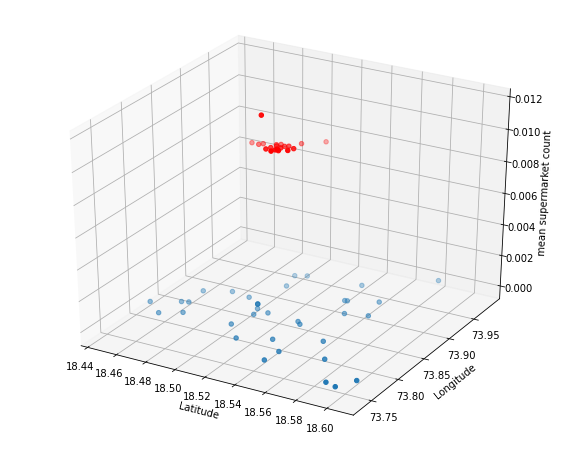

In [99]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

g_low = merged.loc[merged['Cluster Labels'] == 0]
g_high = merged.loc[merged['Cluster Labels'] == 1]

 
ax.scatter( g_low['Latitude'],g_low['Longitude'],g_low['Supermarket'] )
ax.scatter( g_high['Latitude'],g_high['Longitude'],g_high['Supermarket'] , color = 'red' )

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('mean supermarket count')

plt.show()